In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

b_accelerator = True
if not b_accelerator:
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

os.environ["TOKENIZERS_PARALLELISM"] = "false"
    
import torch
from datasets import load_dataset, Dataset
from transformers import BitsAndBytesConfig
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report

from peft import LoraConfig, TaskType, PeftModel, get_peft_model, prepare_model_for_kbit_training

if b_accelerator:
    from accelerate import Accelerator
    from accelerate.utils import set_seed

In [2]:
seed = 3087

if b_accelerator:
    # Initialize accelerator
    accelerator = Accelerator()
    device = accelerator.device
    # num_proc = accelerator.num_processes
    set_seed(seed)
else:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_proc = torch.cuda.device_count()

# Training Params
num_epochs = 16
batch_size = 128//num_proc
learning_rate = 2e-4*num_proc
b_train = True
test_metrics = {}
model_params = {}

In [3]:
# Load a pretrained HF model

model_name = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
# Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [4]:
def print_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
print_trainable_parameters(model)

66955010

In [6]:
# Load and preprocess a dataset

data_name = 'ade_corpus_v2'
dataset_ade = load_dataset(data_name, 'Ade_corpus_v2_classification')
dataset_ade

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 23516
    })
})

In [7]:
train_df = pd.DataFrame(dataset_ade["train"])
train_df

,text,label
0,Intravenous azithromycin-induced ototoxicity.,1
1,"Immobilization, while Paget's bone disease was...",1
2,Unaccountable severe hypercalcemia in a patien...,1
3,METHODS: We report two cases of pseudoporphyri...,1
4,METHODS: We report two cases of pseudoporphyri...,1
...,...,...
23511,"At autopsy, the liver was found to be small, s...",0
23512,"Physical exam revealed a patient with aphasia,...",0
23513,At the time when the leukemia appeared seven o...,0
23514,The American Society for Regional Anesthesia a...,0


In [8]:
# Check for missing data etc
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23516 entries, 0 to 23515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23516 non-null  object
 1   label   23516 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.6+ KB


In [9]:
# Check for duplicates and drop

if train_df.duplicated().sum():
    train_df.drop_duplicates()

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23516 entries, 0 to 23515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23516 non-null  object
 1   label   23516 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.6+ KB


In [10]:
# split data into train/val/test

num_train = int(0.8*len(train_df))
num_val = int(0.1*len(train_df))

train_df, val_test_df = np.split(train_df.sample(frac=1, random_state=seed), [num_train])
val_df, _ = np.split(val_test_df.sample(frac=1, random_state=seed), [num_val])

In [11]:
ds = {}
ds['train'] = Dataset.from_pandas(train_df)
ds['val'] = Dataset.from_pandas(val_df)
ds['val_test'] = Dataset.from_pandas(val_test_df)



In [12]:
def preprocess_function(data, tokenizer):
    """Preprocess the dataset by returning tokenized data"""
    return tokenizer(data['text'], truncation=True, max_length=0)

tokenized_ds = {}
for split in ds.keys():
    tokenized_ds[split] = ds[split].map(preprocess_function, 
                                        batched=True, 
                                        remove_columns=['__index_level_0__', 'text'], 
                                        fn_kwargs={"tokenizer": tokenizer})

Map:   0%|          | 0/18812 [00:00<?, ? examples/s]

Map:   0%|          | 0/2351 [00:00<?, ? examples/s]

Map:   0%|          | 0/4704 [00:00<?, ? examples/s]

In [13]:
tokenized_ds['train'].column_names

['label', 'input_ids', 'attention_mask']

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [15]:
# Training

training_args = TrainingArguments(
    output_dir='tmp',
    num_train_epochs=num_epochs,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    logging_dir='tmp',
    logging_steps=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    report_to="none",
    dataloader_num_workers=num_proc,
    load_best_model_at_end=True,
    overwrite_output_dir=True,
)

training_args

TrainingArguments(
_n_gpu=4,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=4,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=False,
group_by

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['val'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [17]:
# Code from https://github.com/huggingface/peft/blob/v0.9.0/src/peft/peft_model.py#L492
def get_nb_trainable_parameters(model) -> tuple[int, int]:
    r"""
    Returns the number of trainable parameters and the number of all parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        # Due to the design of 4bit linear layers from bitsandbytes
        # one needs to multiply the number of parameters by 2 to get
        # the correct number of parameters
        if param.__class__.__name__ == "Params4bit":
            num_params = num_params * 2

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params

    return trainable_params, all_param

In [18]:
trainable_params, all_param = get_nb_trainable_parameters(model)
model_params['pretrain'] = [trainable_params, all_param]

In [19]:
def plot_confusion_matrix(y_pred_list, y_true_list, labels):
    no_plots = len(y_pred_list)
    _, ax = plt.subplots(1, no_plots, figsize=(6*no_plots, 6))

    if no_plots == 1:
        ax = [ax]
    
    for i in range(no_plots):
        cm = confusion_matrix(y_pred_list[i], y_true_list[i], normalize="true")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap="Blues", values_format=".2f", ax=ax[i], colorbar=False)
        plt.title("Normalized confusion matrix")
        
    plt.show()

In [20]:
#labels = ds["train"].features["label"].names
labels = ["NO_ADE", "ADE"]

In [21]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics['pretrain'] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.6974156498908997,
 'test_accuracy': 0.4085884353741497,
 'test_f1': 0.4257540292163559,
 'test_runtime': 5.0158,
 'test_samples_per_second': 937.835,
 'test_steps_per_second': 7.377}

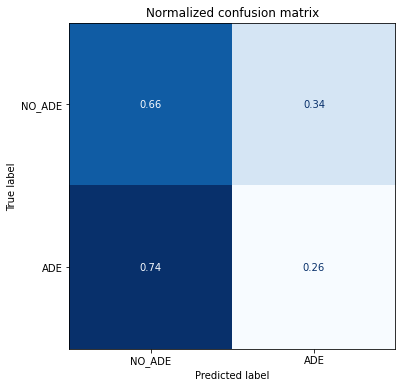

In [22]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [23]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.66      0.35      0.46      3343
           1       0.26      0.56      0.35      1361

    accuracy                           0.41      4704
   macro avg       0.46      0.45      0.40      4704
weighted avg       0.54      0.41      0.43      4704



In [24]:
def train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None, quant_config=None):

    id2label={0: "NO_ADE", 1: "ADE"}  # For converting predictions to strings
    label2id={"NO_ADE": 0, "ADE": 1}

    tokenizer =  AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        quantization_config=quant_config, 
        id2label=id2label,
        label2id=label2id
    )

    if quant_config is not None:
        model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=False)
    else:
        model = model.to(device)
    
    if lora_config is not None:
        model = get_peft_model(model, lora_config)
    else:
        model = PeftModel.from_pretrained(model, model_name, is_trainable=True)
        
    trainable_params, all_param = get_nb_trainable_parameters(model)

    training_args.output_dir = out_dir
    training_args.logging_dir = log_dir
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds['train'],
        eval_dataset=tokenized_ds['val'],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    return trainer, trainable_params, all_param

In [25]:
def plot_train_log_history(log_history, num_epochs, batch_step):
    history = {"loss" : [], "val_loss" : [], "val_accuracy" : [], "val_f1" : []}

    for hist in log_history:
        if len(history['val_loss']) == num_epochs:
            break
        if hist['step']%batch_step == 0:
            if 'loss' in hist.keys():
                history['loss'].append(hist['loss'])
            if 'eval_loss' in hist.keys():
                history['val_loss'].append(hist['eval_loss'])
            if 'eval_accuracy' in hist.keys():
                history['val_accuracy'].append(hist['eval_accuracy'])
            if 'eval_f1' in hist.keys():
                history['val_f1'].append(hist['eval_f1']) 

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), history['loss'], label="Train Loss")
    plt.plot(range(num_epochs), history['val_loss'], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), history['val_accuracy'], label="Val Accuracy")
    plt.plot(range(num_epochs), history['val_f1'], label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy, F1")
    plt.legend()
    
    plt.show()

In [26]:
# Create a PEFT model

# format of cfg_name is targetmodules_rank_scale
cfg_name = "q_r1_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:
    # Lora config with rank 1, scale 1 (scale = lora_alpha/r)
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=1, target_modules=["q_lin"], bias="none", lora_alpha=1, lora_dropout=0.2
    )
   
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [27]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()    
    trainer.save_model(out_dir)   # internally calls save_pretrained for PreTrainedModel, PeftModel
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.337500,0.259003,0.894513,0.892976
2,0.186700,0.216911,0.909826,0.909361
3,0.193300,0.211955,0.909826,0.911213
4,0.178400,0.192499,0.925138,0.924339
5,0.153500,0.180674,0.921310,0.921734
6,0.139800,0.179411,0.925989,0.925801
7,0.202500,0.173197,0.931944,0.931801
8,0.202100,0.175705,0.927265,0.927486
9,0.153800,0.174341,0.932795,0.932986
10,0.155000,0.169114,0.930668,0.930624


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

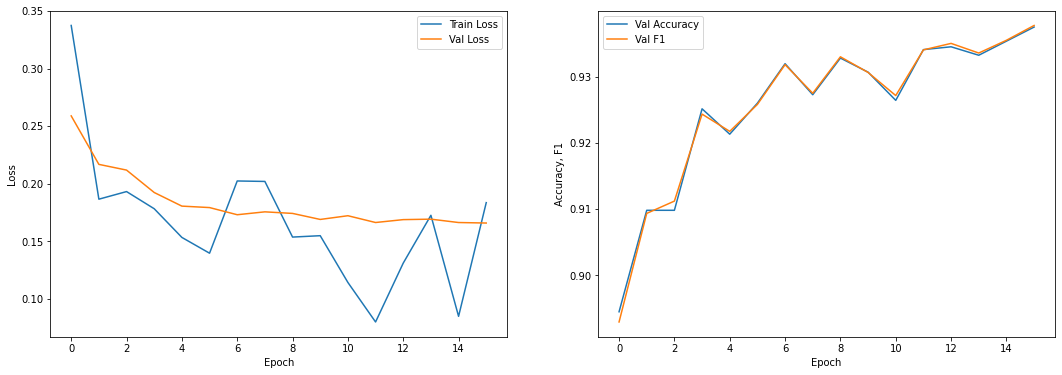

In [28]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [29]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [30]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.16852092742919922,
 'test_accuracy': 0.9340986394557823,
 'test_f1': 0.9344447157915902,
 'test_runtime': 2.0522,
 'test_samples_per_second': 2292.21,
 'test_steps_per_second': 18.03}

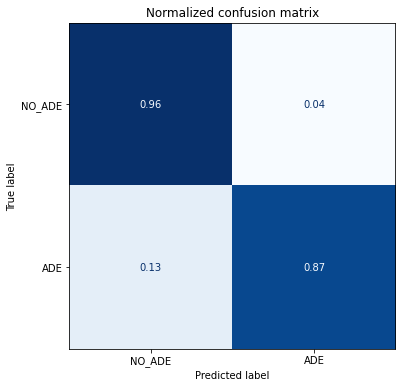

In [31]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [32]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3343
           1       0.87      0.90      0.89      1361

    accuracy                           0.93      4704
   macro avg       0.92      0.93      0.92      4704
weighted avg       0.94      0.93      0.93      4704



In [33]:
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "v_r1_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:    
    # Lora config with rank 1
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=1, target_modules=["v_lin"], bias="none", lora_alpha=1, lora_dropout=0.2
    )    
    
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [34]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.292000,0.289731,0.874096,0.868347
2,0.205400,0.232587,0.908124,0.906694
3,0.241300,0.211808,0.906848,0.907763
4,0.203900,0.201229,0.920885,0.919810
5,0.203400,0.190563,0.918333,0.919319
6,0.138600,0.178359,0.929392,0.929243
7,0.239200,0.174359,0.926414,0.926638
8,0.227500,0.179636,0.921310,0.922247
9,0.165300,0.171604,0.931944,0.932165
10,0.171000,0.169037,0.934071,0.934375


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

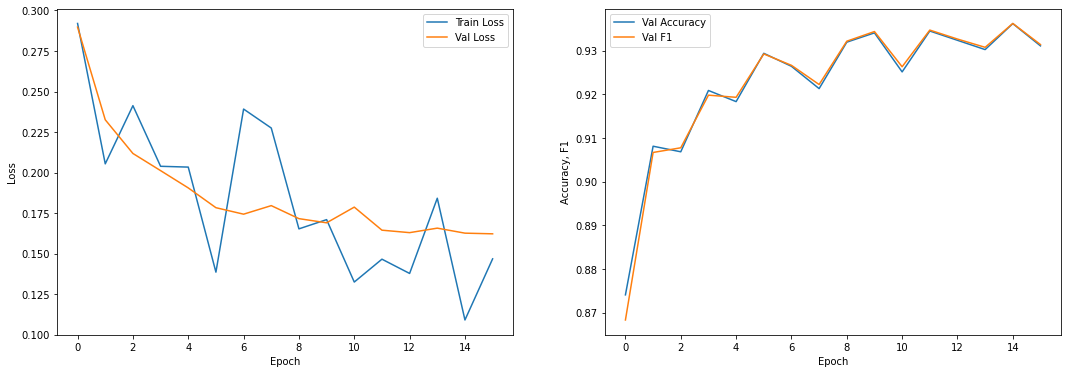

In [35]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [36]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [37]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.17149889469146729,
 'test_accuracy': 0.9292091836734694,
 'test_f1': 0.9295160225912705,
 'test_runtime': 1.9488,
 'test_samples_per_second': 2413.817,
 'test_steps_per_second': 18.986}

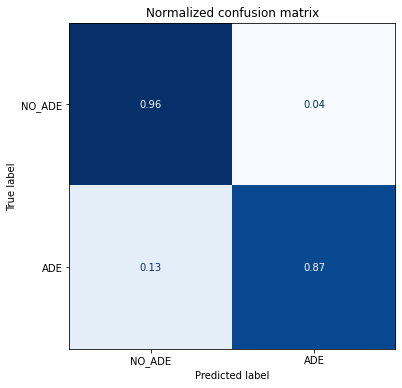

In [38]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [39]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3343
           1       0.87      0.89      0.88      1361

    accuracy                           0.93      4704
   macro avg       0.91      0.92      0.91      4704
weighted avg       0.93      0.93      0.93      4704



In [40]:
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "q_v_r1_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:
    # Lora config with rank 1, qv target modules 
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=1, target_modules=["q_lin", "v_lin"], bias="none", lora_alpha=1, lora_dropout=0.2
    )    

    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [41]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.285100,0.248506,0.896214,0.893439
2,0.178200,0.200564,0.920034,0.919331
3,0.157300,0.192743,0.917057,0.918266
4,0.166300,0.179599,0.934496,0.933670
5,0.139300,0.172456,0.928966,0.929483
6,0.147800,0.163299,0.931944,0.932110
7,0.216900,0.163796,0.934496,0.934129
8,0.193400,0.172178,0.930242,0.930964
9,0.122100,0.162732,0.937473,0.937639
10,0.118100,0.166786,0.939600,0.939675


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

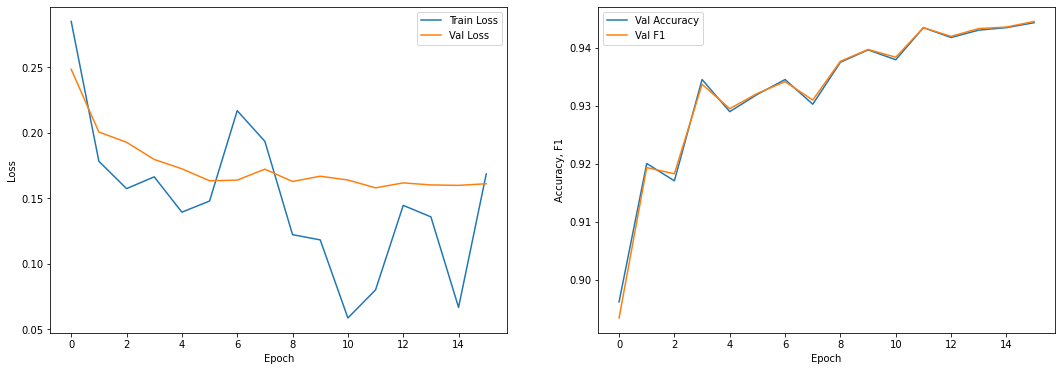

In [42]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [43]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [44]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.15913715958595276,
 'test_accuracy': 0.9402636054421769,
 'test_f1': 0.9403217763076263,
 'test_runtime': 2.3062,
 'test_samples_per_second': 2039.724,
 'test_steps_per_second': 16.044}

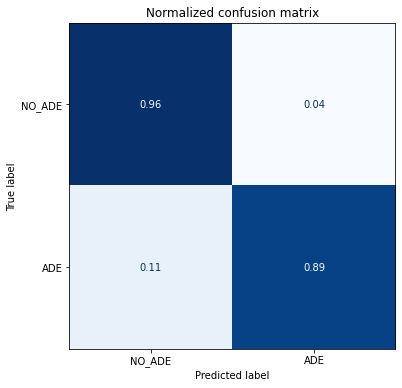

In [45]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [46]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3343
           1       0.89      0.90      0.90      1361

    accuracy                           0.94      4704
   macro avg       0.93      0.93      0.93      4704
weighted avg       0.94      0.94      0.94      4704



In [47]:
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "q_v_k_o_r1_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:    
    # Lora config with rank 1, additional tgt modules
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=1, target_modules=["q_lin", "v_lin", "k_lin", "out_lin"], bias="none", lora_alpha=1, lora_dropout=0.2
    )
    
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [48]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.294800,0.240028,0.901319,0.898624
2,0.185700,0.189238,0.919609,0.918883
3,0.145200,0.182276,0.923437,0.924362
4,0.153000,0.168579,0.937048,0.936068
5,0.134800,0.152474,0.937473,0.937486
6,0.146500,0.150684,0.939600,0.939395
7,0.212300,0.145382,0.941302,0.941350
8,0.127000,0.155580,0.935347,0.936038
9,0.097000,0.150308,0.943428,0.943689
10,0.069600,0.152360,0.941302,0.941606


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

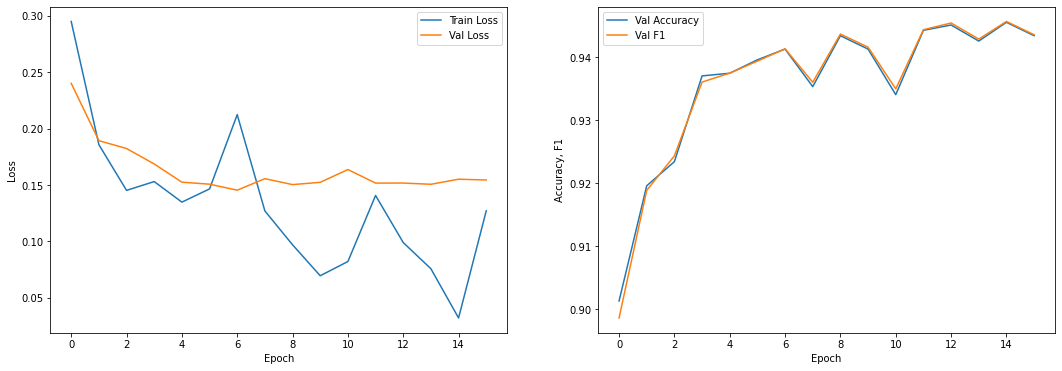

In [49]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [50]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [51]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.15253745019435883,
 'test_accuracy': 0.9377125850340136,
 'test_f1': 0.9378264942948489,
 'test_runtime': 2.7387,
 'test_samples_per_second': 1717.608,
 'test_steps_per_second': 13.51}

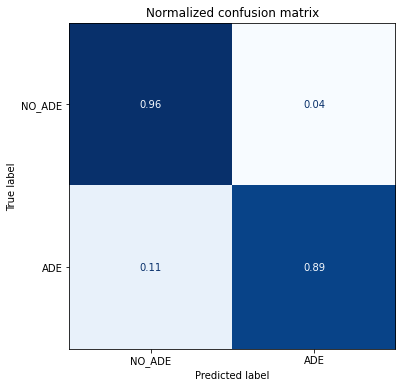

In [52]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [53]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3343
           1       0.89      0.90      0.89      1361

    accuracy                           0.94      4704
   macro avg       0.92      0.93      0.92      4704
weighted avg       0.94      0.94      0.94      4704



In [54]:
# Compare metrics across configs
# format of cfg_name is targetmodules_rank_scale
def compare_metrics(test_metrics, model_params):
    cfgs = list(test_metrics.keys())
    test_accuracy = []
    test_f1 = []
    trainable_params = []
    all_params = []
    
    for key, value in test_metrics.items():
        test_accuracy.append(value['test_accuracy']) 
        test_f1.append(value['test_f1'])
        
    for key, value in model_params.items():
        trainable_params.append(value[0]) 
        all_params.append(value[1])
    
    metrics_df = pd.DataFrame(columns=cfgs, index=['accuracy','f1', 'trainable_params', 'all_params'])
    metrics_df.loc['accuracy'] = test_accuracy
    metrics_df.loc['f1'] = test_f1
    metrics_df.loc['trainable_params'] = trainable_params
    metrics_df.loc['all_params'] = all_params
    return metrics_df

In [55]:
compare_metrics(test_metrics, model_params)

,pretrain,q_r1_s1,v_r1_s1,q_v_r1_s1,q_v_k_o_r1_s1
accuracy,0.408588,0.934099,0.929209,0.940264,0.937713
f1,0.425754,0.934445,0.929516,0.940322,0.937826
trainable_params,66955010,601346,601346,610562,628994
all_params,66955010,67556356,67556356,67565572,67584004


In [56]:
# Keep the best of different target_modules
test_metrics_n = {}
test_metrics_n['pretrain']  = test_metrics['pretrain'] 
test_metrics_n['q_v_r1_s1'] = test_metrics['q_v_r1_s1']

model_params_n = {}
model_params_n['pretrain']  = model_params['pretrain'] 
model_params_n['q_v_r1_s1'] = model_params['q_v_r1_s1']

test_metrics = test_metrics_n
model_params = model_params_n

In [57]:
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "q_v_r1_s2"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:    
    # Lora config with rank 1, additional tgt modules
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=1, target_modules=["q_lin", "v_lin"], bias="none", lora_alpha=2, lora_dropout=0.2
    )
    
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [58]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.278500,0.221551,0.913654,0.912874
2,0.160300,0.189012,0.925989,0.925541
3,0.145100,0.184371,0.920885,0.922102
4,0.167600,0.170833,0.933645,0.933031
5,0.147000,0.166430,0.933220,0.933828
6,0.157700,0.157723,0.937473,0.937512
7,0.209700,0.159685,0.937048,0.936807
8,0.165000,0.174859,0.928966,0.929909
9,0.112500,0.159962,0.938749,0.938899
10,0.105000,0.164365,0.940026,0.939861


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

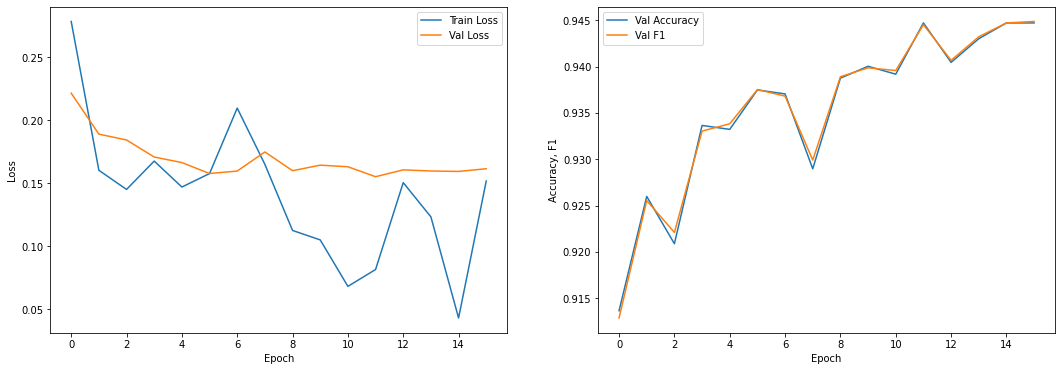

In [59]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [60]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [61]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.1594163477420807,
 'test_accuracy': 0.9409013605442177,
 'test_f1': 0.9408365326840393,
 'test_runtime': 2.2337,
 'test_samples_per_second': 2105.886,
 'test_steps_per_second': 16.564}

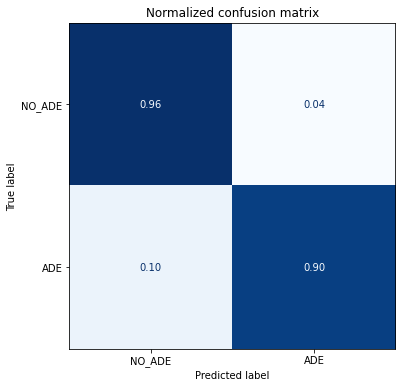

In [62]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [63]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3343
           1       0.90      0.89      0.90      1361

    accuracy                           0.94      4704
   macro avg       0.93      0.93      0.93      4704
weighted avg       0.94      0.94      0.94      4704



In [64]:
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "q_v_r4_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:    
    # Lora config with rank 4, additional tgt modules
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=4, target_modules=["q_lin", "v_lin"], bias="none", lora_alpha=4, lora_dropout=0.2
    )
    
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [65]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.261500,0.206188,0.913228,0.912050
2,0.131200,0.178700,0.928966,0.928981
3,0.122600,0.172892,0.921735,0.922864
4,0.152600,0.159817,0.936623,0.935931
5,0.122600,0.149575,0.941302,0.941515
6,0.131200,0.146070,0.943854,0.943969
7,0.175000,0.146472,0.941727,0.941491
8,0.174300,0.155573,0.937048,0.937655
9,0.081900,0.154581,0.941727,0.941763
10,0.050600,0.155016,0.942578,0.942752


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

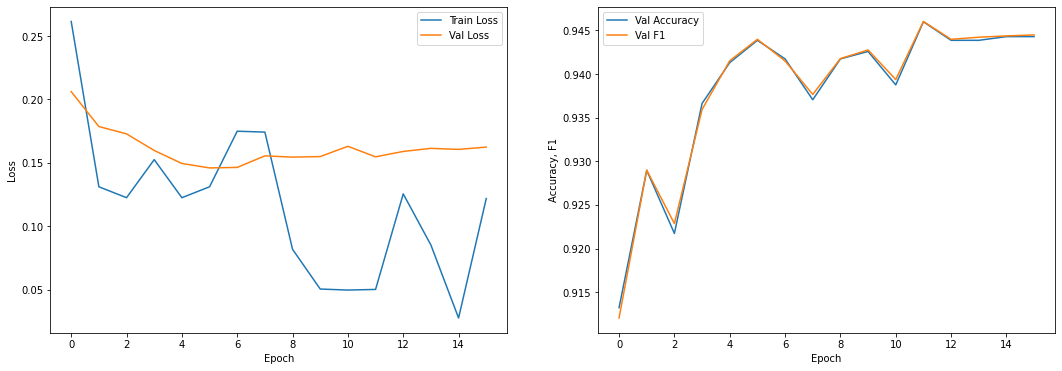

In [66]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [67]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [68]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.15624122321605682,
 'test_accuracy': 0.9398384353741497,
 'test_f1': 0.940086842725782,
 'test_runtime': 2.1097,
 'test_samples_per_second': 2229.673,
 'test_steps_per_second': 17.538}

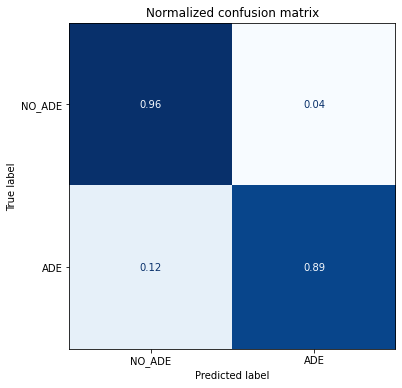

In [69]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [70]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3343
           1       0.89      0.91      0.90      1361

    accuracy                           0.94      4704
   macro avg       0.92      0.93      0.93      4704
weighted avg       0.94      0.94      0.94      4704



In [71]:
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "q_v_r8_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:    
    # Lora config with rank 8, additional tgt modules
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=8, target_modules=["q_lin", "v_lin"], bias="none", lora_alpha=8, lora_dropout=0.2
    )
    
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [72]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.265400,0.195426,0.920885,0.919964
2,0.125300,0.172982,0.934496,0.934302
3,0.124400,0.164181,0.926414,0.927189
4,0.141100,0.153049,0.945130,0.944785
5,0.106200,0.152894,0.941302,0.941584
6,0.117500,0.147092,0.945555,0.945440
7,0.118300,0.150015,0.948533,0.948770
8,0.131600,0.157384,0.937899,0.938385
9,0.091000,0.158663,0.943854,0.943735
10,0.035400,0.166135,0.944704,0.944970


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

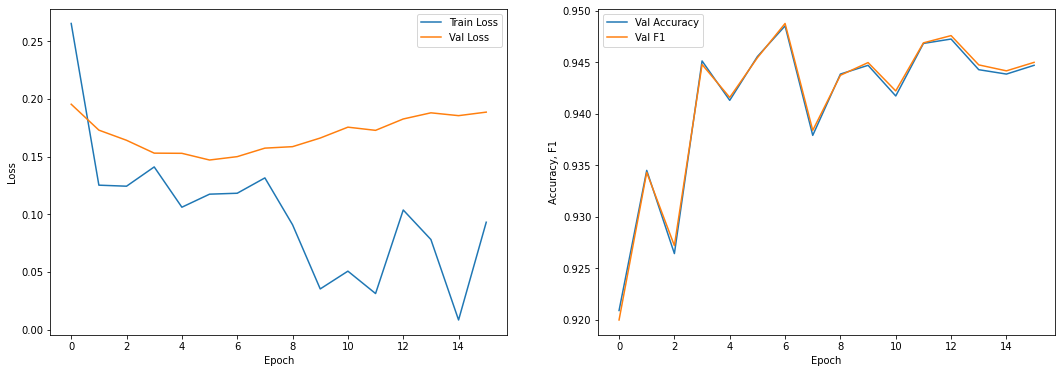

In [73]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [74]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [75]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.15537989139556885,
 'test_accuracy': 0.9415391156462585,
 'test_f1': 0.9414814418186288,
 'test_runtime': 2.3698,
 'test_samples_per_second': 1984.937,
 'test_steps_per_second': 15.613}

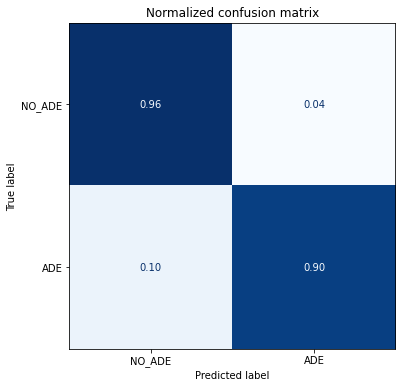

In [76]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [77]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3343
           1       0.90      0.90      0.90      1361

    accuracy                           0.94      4704
   macro avg       0.93      0.93      0.93      4704
weighted avg       0.94      0.94      0.94      4704



In [78]:
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "q_v_r16_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:    
    # Lora config with rank 16, additional tgt modules
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=16, target_modules=["q_lin", "v_lin"], bias="none", lora_alpha=16, lora_dropout=0.2
    )
    
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [79]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.251800,0.189993,0.923437,0.922128
2,0.111400,0.164458,0.935347,0.935183
3,0.101600,0.167383,0.927690,0.928917
4,0.110400,0.146495,0.946831,0.946616
5,0.109700,0.163866,0.937048,0.937765
6,0.071500,0.154030,0.943854,0.944036
7,0.103500,0.154120,0.944704,0.944949
8,0.090800,0.168691,0.939600,0.940371
9,0.058100,0.170351,0.944704,0.944927
10,0.015500,0.181430,0.949809,0.950127


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

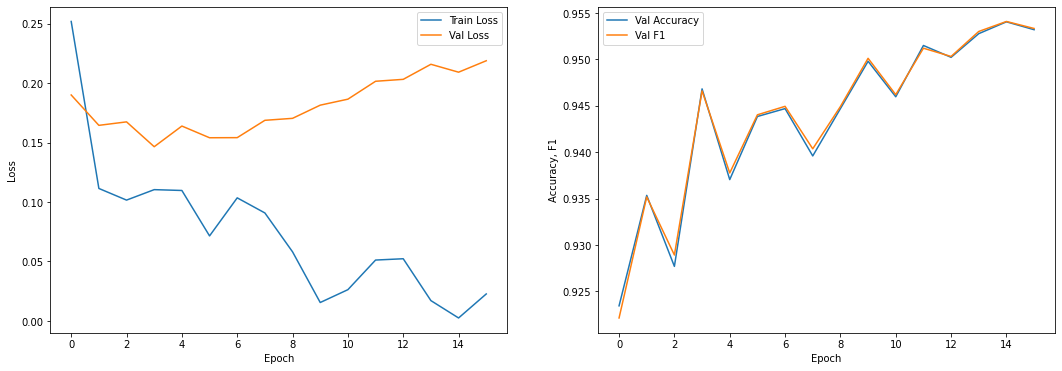

In [80]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [81]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [82]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.15368396043777466,
 'test_accuracy': 0.9415391156462585,
 'test_f1': 0.9413505801715272,
 'test_runtime': 3.6065,
 'test_samples_per_second': 1304.324,
 'test_steps_per_second': 10.259}

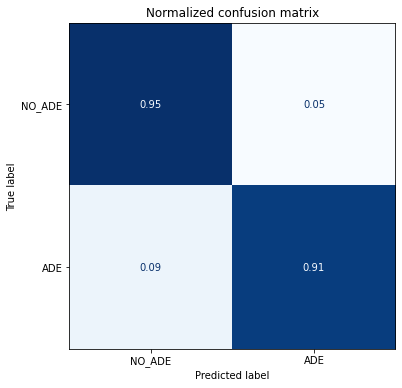

In [83]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [84]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3343
           1       0.91      0.89      0.90      1361

    accuracy                           0.94      4704
   macro avg       0.93      0.93      0.93      4704
weighted avg       0.94      0.94      0.94      4704



In [85]:
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "q_v_r32_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:    
    # Lora config with rank 16, additional tgt modules
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=32, target_modules=["q_lin", "v_lin"], bias="none", lora_alpha=32, lora_dropout=0.2
    )
    
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config)

In [86]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.255600,0.180132,0.930668,0.929743
2,0.101200,0.153642,0.936623,0.937130
3,0.097600,0.161661,0.934496,0.935398
4,0.103100,0.137911,0.951935,0.951612
5,0.082800,0.155484,0.944279,0.944684
6,0.080300,0.155800,0.945555,0.945510
7,0.041200,0.176235,0.942152,0.942584
8,0.033200,0.180663,0.939175,0.939982
9,0.066800,0.202075,0.950234,0.950118
10,0.035900,0.216922,0.948533,0.948829


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

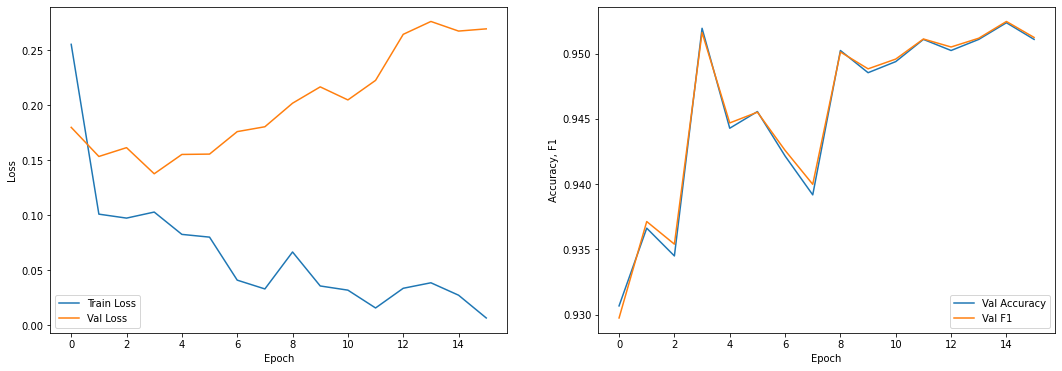

In [87]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [88]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [89]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.14528757333755493,
 'test_accuracy': 0.9470663265306123,
 'test_f1': 0.9469076179826642,
 'test_runtime': 2.0671,
 'test_samples_per_second': 2275.669,
 'test_steps_per_second': 17.9}

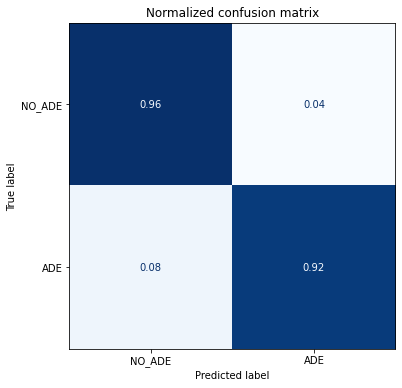

In [90]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [91]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3343
           1       0.92      0.90      0.91      1361

    accuracy                           0.95      4704
   macro avg       0.94      0.93      0.94      4704
weighted avg       0.95      0.95      0.95      4704



In [92]:
compare_metrics(test_metrics, model_params)

,pretrain,q_v_r1_s1,q_v_r1_s2,q_v_r4_s1,q_v_r8_s1,q_v_r16_s1,q_v_r32_s1
accuracy,0.408588,0.940264,0.940901,0.939838,0.941539,0.941539,0.947066
f1,0.425754,0.940322,0.940837,0.940087,0.941481,0.941351,0.946908
trainable_params,66955010,610562,610562,665858,739586,887042,1181954
all_params,66955010,67565572,67565572,67620868,67694596,67842052,68136964


In [93]:
# QLoRA — Quantized Low Rank Adaption Method
# Create a PEFT model for a new lora config

# format of cfg_name is targetmodules_rank_scale
cfg_name = "qlora_q_v_r8_s1"
out_dir = os.path.join('submission', cfg_name)
log_dir = os.path.join(out_dir, 'logs')

if b_train:    
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4"
        # bnb_4bit_use_double_quant=True,
        # bnb_4bit_compute_dtype="torch.float16"
    )
    
    # Lora config with rank 16, additional tgt modules
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, r=8, target_modules=["q_lin", "v_lin"], bias="none", lora_alpha=8, lora_dropout=0.2
    )
    
    trainer, _, _ = train_eval_setup(model_name, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=lora_config, quant_config=quant_config)

In [94]:
# Train and save the PEFT model

if b_train:
    if b_accelerator:
        trainer = accelerator.prepare(trainer)
    
    trainer.train()
    trainer.save_model(out_dir)
    trainer.save_state()

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.254000,0.200768,0.920459,0.918915
2,0.120700,0.172437,0.928966,0.929040
3,0.103800,0.181973,0.919183,0.920628
4,0.134900,0.154418,0.940026,0.939313
5,0.128800,0.150674,0.940026,0.940506
6,0.123700,0.149828,0.947256,0.947054
7,0.141400,0.143952,0.944279,0.944515
8,0.136600,0.160788,0.939600,0.940268
9,0.068500,0.163135,0.945980,0.946036
10,0.048200,0.170093,0.947256,0.947530


/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warn

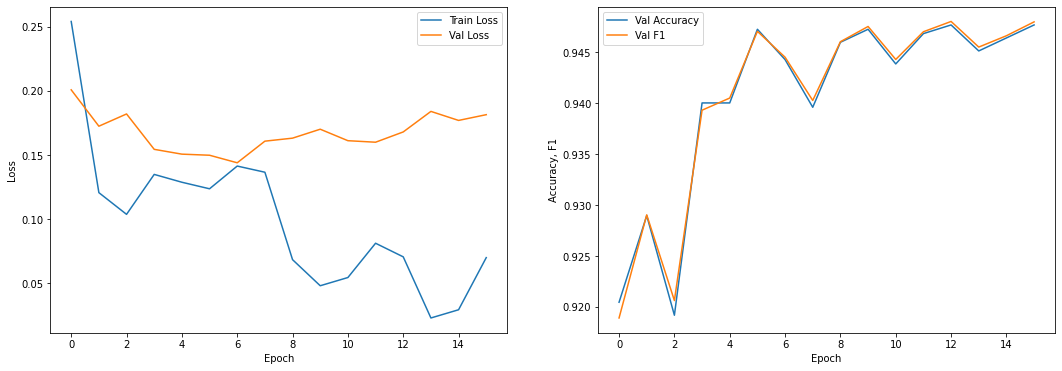

In [95]:
if b_train:
    batch_step = len(tokenized_ds['train'])/(trainer.args._n_gpu*batch_size)
    batch_step = int(round(batch_step+0.5))

    plot_train_log_history(trainer.state.log_history, num_epochs, batch_step)

In [96]:
# Load the saved PEFT model

trainer, trainable_params, all_param = train_eval_setup(out_dir, tokenized_ds, device, training_args, out_dir, log_dir, lora_config=None)
model_params[cfg_name] = [trainable_params, all_param]

In [97]:
# Evaluate the fine-tuned model

preds_val_test = trainer.predict(tokenized_ds["val_test"])
test_metrics[cfg_name] = preds_val_test.metrics

preds_val_test.metrics

/usr/lib/python3/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.15724065899848938,
 'test_accuracy': 0.9413265306122449,
 'test_f1': 0.9415868611568118,
 'test_runtime': 4.9331,
 'test_samples_per_second': 953.566,
 'test_steps_per_second': 7.5}

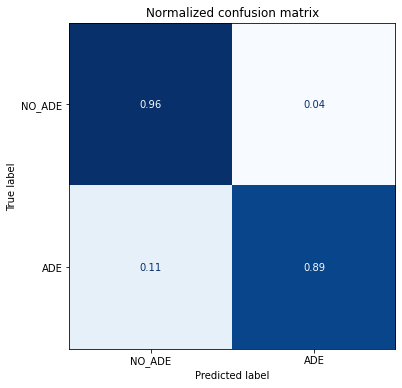

In [98]:
preds_val_test = np.argmax(preds_val_test.predictions, axis=1)

plot_confusion_matrix([preds_val_test], [ds['val_test']['label']], labels)

In [99]:
report_val_test = classification_report(ds['val_test']['label'], preds_val_test)
print(report_val_test)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3343
           1       0.89      0.91      0.90      1361

    accuracy                           0.94      4704
   macro avg       0.93      0.93      0.93      4704
weighted avg       0.94      0.94      0.94      4704



In [100]:
compare_metrics(test_metrics, model_params)

,pretrain,q_v_r1_s1,q_v_r1_s2,q_v_r4_s1,q_v_r8_s1,q_v_r16_s1,q_v_r32_s1,qlora_q_v_r8_s1
accuracy,0.408588,0.940264,0.940901,0.939838,0.941539,0.941539,0.947066,0.941327
f1,0.425754,0.940322,0.940837,0.940087,0.941481,0.941351,0.946908,0.941587
trainable_params,66955010,610562,610562,665858,739586,887042,1181954,739586
all_params,66955010,67565572,67565572,67620868,67694596,67842052,68136964,67694596


In [ ]:
# Observations
# In general there's not a big difference in metrics for different ranks. 
# q_v_r8_s1 has the best results. 
# And qlora_q_v_r8_s1 matches q_v_r8_s1